# Stock Price Prediction using Moving Average Method

> Source: [Medium Article](https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001)

In this notebook, we aim to predict the daily adjusted closing prices of Vanguard Stock Market ETF (**`VTI`**). We will use the historical prices of three years from `2015-11-25` and `2018-11-23`

In [1]:
import pandas_datareader.data as web
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import date, datetime, time, timedelta

In [2]:
start = datetime(2015, 11, 25)
end = datetime(2018, 11, 23)
data = web.DataReader('VTI', 'yahoo', start, end)

In [3]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-25,107.660004,107.250000,107.510002,107.470001,1820300.0,99.990135
2015-11-27,107.760002,107.220001,107.589996,107.629997,552400.0,100.139000
2015-11-30,107.849998,107.110001,107.779999,107.169998,3618100.0,99.711006
2015-12-01,108.209999,107.370003,107.589996,108.180000,2443600.0,100.650711
2015-12-02,108.269997,106.879997,108.099998,107.050003,2937200.0,99.599350


We will use three prediction models to predict the stock price of **`VTI`** ETF

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Prediction Model using Moving Average

### Moving Average
In the moving average method, the predicted value will be the mean of the previous `N` values. In our context, this means we set the current adjusted closing price as the mean of the adjusted closing price of the previous `N` days. The hyperparameter `N` needs to be tuned.

In [5]:
# Input Params
Nmax = 21
fontsize = 14
ticklabelsize = 14

def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    pred_list = df[target_col].rolling(window=N, min_periods=1).mean()
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set them to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    return pred_list[offset:]

def get_mape(y_true, y_pred):
    """
        Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
data.columns = [str(x).lower().replace(' ', '-') for x in data.columns]
data['month'] = data.index.values.astype('datetime64[M]').astype(int) % 12 + 1
data.head(10)

,high,low,open,close,volume,adj-close,month
Date,,,,,,,
2015-11-25,107.660004,107.250000,107.510002,107.470001,1820300.0,99.990135,11
2015-11-27,107.760002,107.220001,107.589996,107.629997,552400.0,100.139000,11
2015-11-30,107.849998,107.110001,107.779999,107.169998,3618100.0,99.711006,11
2015-12-01,108.209999,107.370003,107.589996,108.180000,2443600.0,100.650711,12
2015-12-02,108.269997,106.879997,108.099998,107.050003,2937200.0,99.599350,12
2015-12-03,107.480003,105.059998,107.290001,105.449997,3345600.0,98.110725,12
2015-12-04,107.540001,105.620003,105.809998,107.389999,4520000.0,99.915688,12
2015-12-07,107.269997,106.059998,107.230003,106.550003,3000500.0,99.134171,12
2015-12-08,106.400002,105.269997,105.940002,105.910004,3149600.0,98.538704,12


Text(0.5, 1.0, 'Adjusted Closing Price')

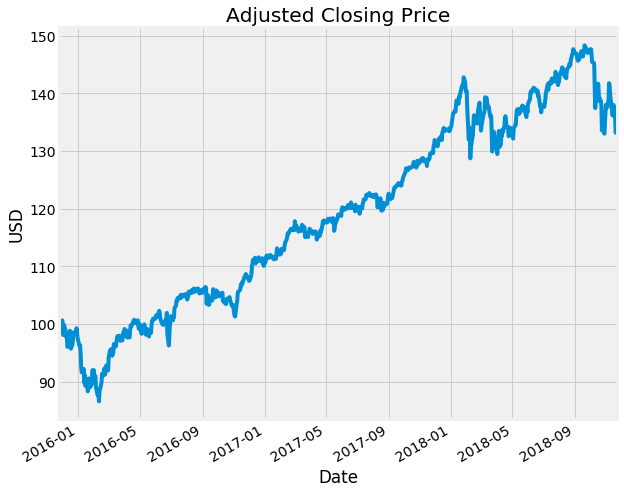

In [7]:
%matplotlib inline
plt.figure(figsize=(10, 8))
# print(plt.style.available)
plt.style.use('fivethirtyeight')

adj_close = data['adj-close']
ax = adj_close.plot(label='adj-close')
ax.set_ylabel("USD")
ax.set_title('Adjusted Closing Price')

## Split the data into train, validation and test set

We will split the dataset into $60\%$ training, $20\%$ validation and $20\%$ testing dataset. The prediction model will be trained using the training dataset, model hyperparameters will be tuned using the validation set, and finally the performance of the model will be evaluated using the test dataset.

In [8]:
test_size = 0.2
cv_size = 0.2

num_cv = int(cv_size * len(data))
num_test = int(test_size * len(data))
num_train = len(data) - num_cv - num_test
print("Training Data Size: {}".format(num_train))
print("Validation Data Size: {}".format(num_cv))
print("Testing Data Size: {}".format(num_test))

Training Data Size: 453
Validation Data Size: 151
Testing Data Size: 151


In [9]:
# TODO: Replace these below methods to use train_test_split method from sklearn.model_selection
train = data[:num_train]
cv = data[num_train:num_train + num_cv]
train_cv = data[:num_train + num_cv]
test = data[num_train + num_cv:]

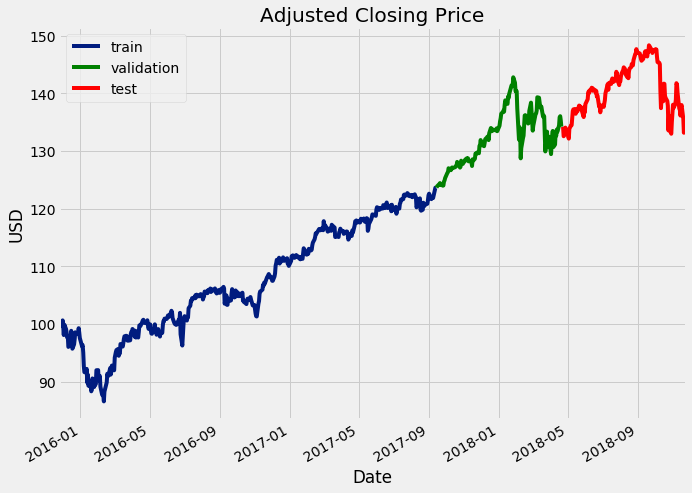

In [10]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn-dark-palette')
ax = train['adj-close'].plot()
ax = cv['adj-close'].plot(color='g', ax=ax)
ax = test['adj-close'].plot(color='r', ax=ax)
ax.set_ylabel('USD')
ax.set_title('Adjusted Closing Price')
ax.legend(['train', 'validation', 'test'])

In [11]:
RMSE = []
mape = []

for N in range(2, Nmax + 1):
    # N is the no. of samples to be used to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'adj-close', N, 0, num_train)
    cv['est_N{}'.format(str(N))] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj-close'])))
    mape.append(get_mape(cv['adj-close'], est_list))

/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

### Plots of RMSE vs N & MAPE vs N

([<matplotlib.axis.XTick at 0x7f1851b6ed68>,
 <a list of 5 Text xticklabel objects>)

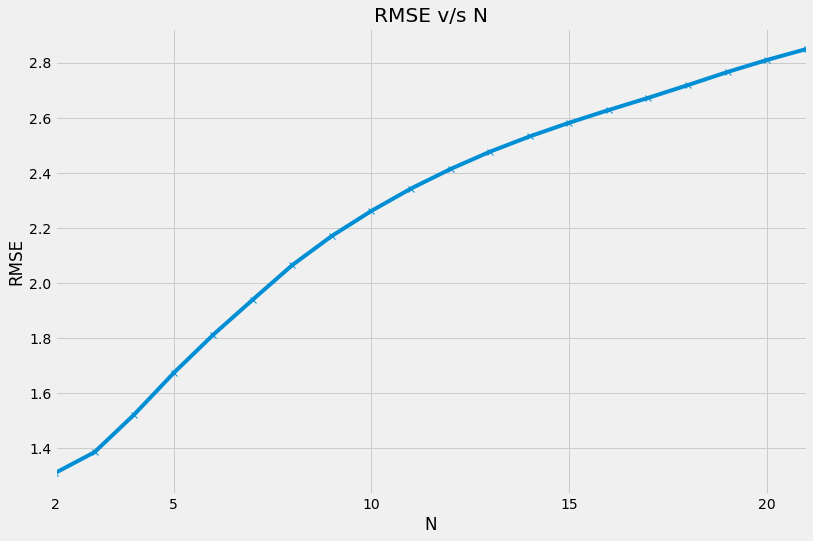

In [12]:
plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
plt.plot(range(2, Nmax+1), RMSE, 'x-')
plt.xlabel('N')
plt.ylabel('RMSE')
plt.title('RMSE v/s N')
plt.xlim([2, Nmax])
plt.xticks([2] + [val for val in range(5, Nmax+1, 5)])

In [13]:
plt.style.available

['Solarize_Light2',
 'seaborn-deep',
 'grayscale',
 'seaborn-darkgrid',
 'seaborn-colorblind',
 'fivethirtyeight',
 'seaborn-notebook',
 'seaborn-talk',
 'seaborn-pastel',
 'seaborn-dark',
 'dark_background',
 '_classic_test',
 'tableau-colorblind10',
 'bmh',
 'seaborn',
 'ggplot',
 'seaborn-white',
 'seaborn-muted',
 'seaborn-ticks',
 'fast',
 'seaborn-whitegrid',
 'seaborn-poster',
 'classic',
 'seaborn-paper',
 'seaborn-dark-palette',
 'seaborn-bright']

From the above plot, we can determine that using the `2` previous days adjusting closing price average as the current day's predicted adjusted closing price is an optimal choice.

([<matplotlib.axis.XTick at 0x7f1851b57710>,
 <a list of 5 Text xticklabel objects>)

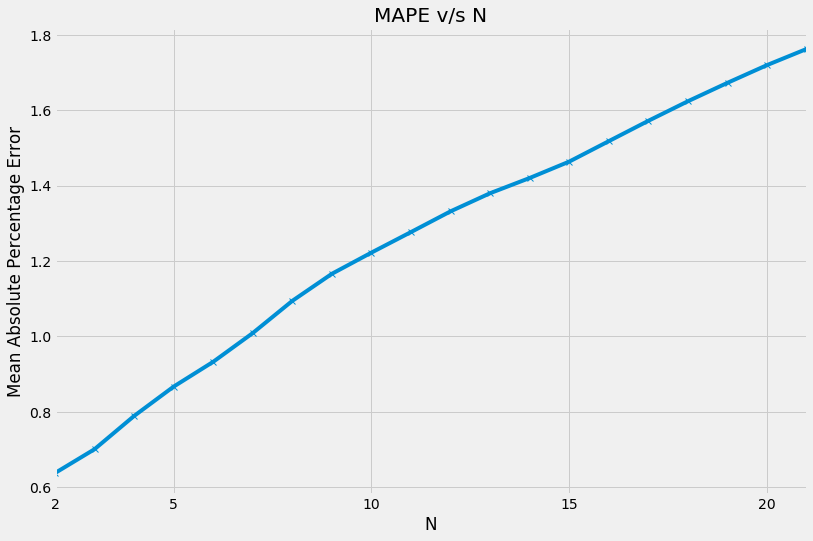

In [14]:
# Plot MAPE versus N
plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
plt.plot(range(2, Nmax+1), mape, 'x-')
plt.xlabel('N')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('MAPE v/s N')
plt.xlim([2, Nmax])
plt.xticks([2] + [val for val in range(5, Nmax+1, 5)])

In [15]:
# +1 is added because the N value starts from 2
N_opt = np.argmin(np.array([float('Inf')] + mape), axis=0) + 1
print("Optimal previous days data to use to predict current day's price is {}".format(N_opt))

Optimal previous days data to use to predict current day's price is 2


### Plot the prediction on validation set

Text(0.5, 1.0, 'Adjusted Closing Price')

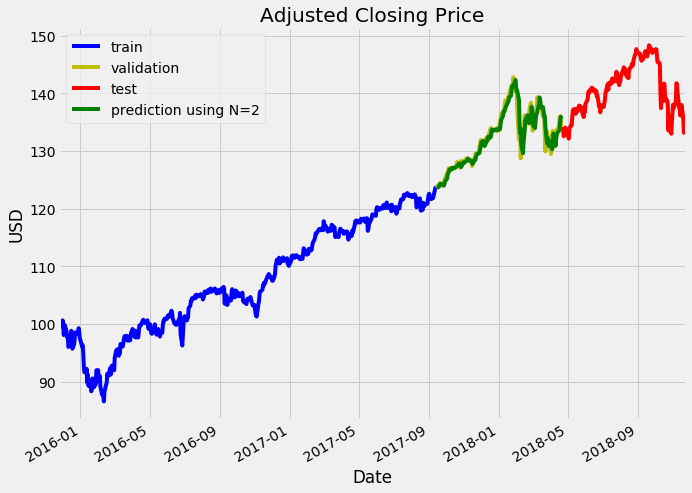

In [16]:
plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
ax = train['adj-close'].plot(style='b-', grid=True)
ax = cv['adj-close'].plot(style='y-', grid=True, ax=ax)
ax = test['adj-close'].plot(style='r-', grid=True, ax=ax)
ax = cv['est_N{}'.format(N_opt)].plot(style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'prediction using N={}'.format(N_opt)])
ax.set_ylabel('USD')
ax.set_title('Adjusted Closing Price')

### Zoom into the Prediction on the Validation Set

Text(0.5, 1.0, 'Adjusted Closing Price')

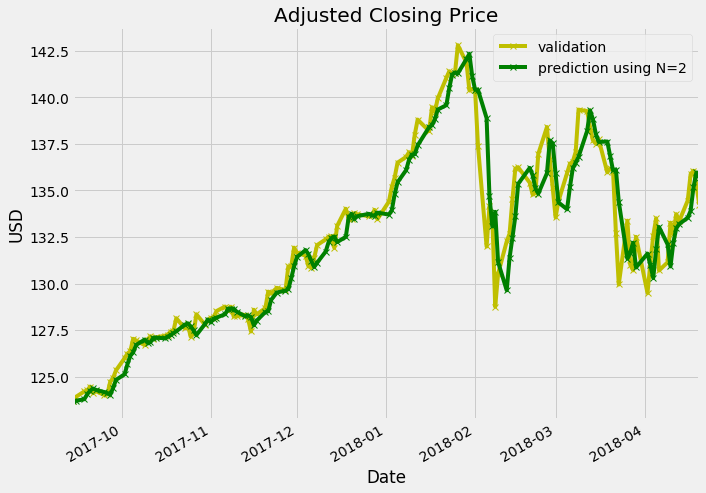

In [17]:
plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
ax = cv['adj-close'].plot(style='yx-', grid=True)
ax = cv['est_N{}'.format(N_opt)].plot(style='gx-', grid=True, ax=ax)
ax.legend(['validation', 'prediction using N={}'.format(N_opt)])
ax.set_ylabel('USD')
ax.set_title('Adjusted Closing Price')

## Final Model

In [18]:
# Making the Predictions on Test Dataset
est_list = get_preds_mov_avg(data, 'adj-close', N_opt, 0, num_train+num_cv)
test['est_N{}'.format(N_opt)] = est_list
print("RMSE = {0:.3f}".format(math.sqrt(mean_squared_error(est_list, test['adj-close']))))
print("MAPE = {0:.3f}%".format(get_mape(test['adj-close'], est_list)))

RMSE = 1.251
MAPE = 0.640%


/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# Lets take a quick look at a few predictions
test.head()

,high,low,open,close,volume,adj-close,month,est_N2
Date,,,,,,,,
2018-04-23,138.160004,136.809998,137.779999,137.449997,2033700.0,134.196945,4,134.782768
2018-04-24,138.190002,134.860001,138.100006,135.800003,3053500.0,132.586014,4,134.221359
2018-04-25,136.250000,134.610001,135.770004,135.949997,2275400.0,132.732452,4,133.391479
2018-04-26,137.679993,136.250000,136.520004,137.240005,1284600.0,133.991913,4,132.659233
2018-04-27,137.740005,136.800003,137.539993,137.330002,1133600.0,134.079803,4,133.362183


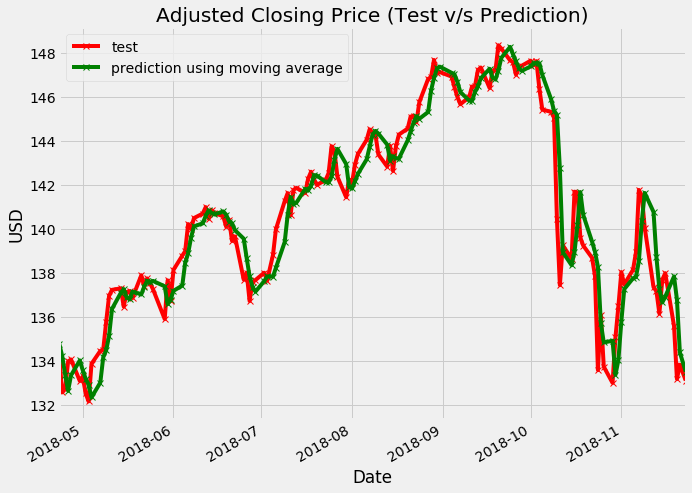

In [20]:
plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
ax = test['adj-close'].plot(style='rx-', grid=True)
ax = test['est_N2'].plot(style='gx-', grid=True, ax=ax)
ax.set_ylabel('USD')
ax.set_title('Adjusted Closing Price (Test v/s Prediction)')
# ax.legend(['test', 'prediction with N={}'.format(N_opt)])
ax.legend(['test', 'prediction using moving average'])